In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.utils.data import download_file

In [3]:
from bs4 import BeautifulSoup

bs = BeautifulSoup(open(download_file('http://svo2.cab.inta-csic.es/theory/fps3/fps.php')).read())

/Users/bmmorris/anaconda/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/bmmorris/anaconda/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [4]:
all_options = [b.attrs['value'] for b in bs.find_all('option')]
instruments = all_options[1:all_options.index('', 1)]
facilities = all_options[all_options.index('', 1)+1:all_options.index('', 150)]
photometric_system = all_options[all_options.index('', 150)+1:]

In [6]:
from astropy.table import Table

bessel_filters = Table.read(download_file('http://svo2.cab.inta-csic.es/theory/fps3/fps.php?PhotSystem=Bessell'), format='votable')
bessel_links = [i for i in bessel_filters['TrasmissionCurve'] if 'Generic' in str(i)]

In [7]:
include_facilities = facilities #['2MASS', 'SLOAN', 'Kepler', 'TESS']

In [8]:
include_facilities

['2MASS',
 'AAO',
 'AKARI',
 'Astrosat',
 'Atlas',
 'BOK',
 'CAHA',
 'CFHT',
 'COBE',
 'CRTS',
 'CTIO',
 'DDO',
 'Euclid',
 'GAIA',
 'GALEX',
 'Gemini',
 'Gemini,CTIO',
 'GTC',
 'Herschel',
 'Hipparcos',
 'HST',
 'IAC80',
 'ING',
 'INT',
 'IRAS',
 'ISO',
 'IUE',
 'JWST',
 'Keck',
 'Kepler',
 'KPNO',
 'La Silla',
 'LasCumbres',
 'LBT',
 'LCO',
 'LICK',
 'LSST',
 'LT',
 'McDonalds',
 'MKO',
 'MMT',
 'MSX',
 'NIRT',
 'NOT',
 'OAF',
 'OAJ',
 'OSN',
 'Palomar',
 'PAN-STARRS',
 'Paranal',
 'ROTSE',
 'SAO',
 'Scorpio',
 'SkyMapper',
 'SLOAN',
 'SOFIA',
 'Spitzer',
 'STELLA',
 'Subaru',
 'Swift',
 'TCS',
 'TD1',
 'TESS',
 'TJO',
 'TNG',
 'TNO',
 'TYCHO',
 'UKIRT',
 'VATT',
 'WFIRST',
 'WHT',
 'WISE',
 'WIYN',
 'Xinglong',
 'XMM']

In [10]:
filters = []

for facility in include_facilities: 
    print(facility)
    filters.append(Table.read(download_file('http://svo2.cab.inta-csic.es/theory/fps3/fps.php?Facility={0}'
                                    .format(facility.replace(" ", "%20")), timeout=300, cache=True), format='votable'))

links = [[i for i in filt['TrasmissionCurve']] 
         for filt in filters]
# print(links)

2MASS
AAO
AKARI
Astrosat
Atlas
BOK
CAHA


CFHT
COBE
CRTS
CTIO
DDO
Euclid


GAIA
GALEX
Gemini
Gemini,CTIO
GTC
Herschel
Hipparcos
HST


IAC80
ING
INT
IRAS
ISO


IUE
JWST
Keck
Kepler
KPNO
La Silla
LasCumbres
LBT


LCO
LICK
LSST
LT
McDonalds
MKO
MMT


MSX
NIRT
NOT
OAF
OAJ
OSN
Palomar
PAN-STARRS
Paranal


ROTSE
SAO
Scorpio
SkyMapper
SLOAN
SOFIA
Spitzer
STELLA


Subaru
Swift
TCS
TD1
TESS
TJO


TNG
TNO
TYCHO
UKIRT
VATT
WFIRST
WHT
WISE
WIYN


Xinglong
XMM


In [11]:
tables = dict()

In [15]:
for facility_links in links: 
    for link in facility_links:
        name = link.decode().split('=')[1]
        if name not in tables.keys() and name not in ['Scorpio/Comet.CO+']: 
            path = download_file(link.decode().replace('+', '&#43;'), cache=True)
            tables[name] = Table.read(path)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


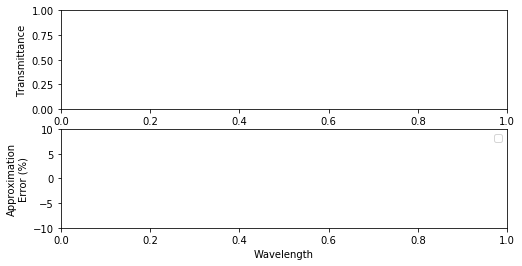

In [173]:
rows = dict()
n_terms = 10

fig, ax = plt.subplots(2, 1, figsize=(8, 4))

for k, v in tables.items(): 

    wl, tr = v['Wavelength'], v['Transmission']
    
#     ax[0].plot(wl, tr, label=k, color='C0')

    diff_wl = np.diff(wl)
    
    delta_lambda = np.nanmedian(diff_wl[diff_wl != 0])
    lambda_0 = wl.min()
    n_lambda = len(wl)
    
    # Create a simplified wavelength grid: 
    simplified_wavelength = np.arange(lambda_0, (n_lambda + 1) * delta_lambda + lambda_0, delta_lambda)
    tr_max = tr.max()
    
    # Interpolate transmittance onto simplified wavelength grid: 
    tr_interp = np.interp(simplified_wavelength, wl, tr)
    
    # Take the DFT of the interpolated transmittance curve
    fft = np.fft.fft(tr_interp)[:n_terms]
    
    # Use the first `n_terms` of the Fourier series to approximate the transmittance curve
    ifft = np.fft.ifft(fft, n=len(simplified_wavelength))
    ifft_real = ifft.real
    
    # Scale the resulting reconstructed transmittance curve
    normalized_fft = (ifft_real - ifft_real.min()) * tr_max / ifft_real.ptp()
    
#     ax[0].plot(simplified_wavelength, normalized_fft, ls='--', label=k+' fft', color='C1')

#     ax[0].annotate(k.split('.')[1], rotation=90,
#                    xy=(simplified_wavelength[np.argmax(normalized_fft)], 0.8 * normalized_fft.max()))
    
#     ax[1].plot(simplified_wavelength, 100*(np.interp(simplified_wavelength, wl, tr) - normalized_fft), label=k)
    
    # Save results in a dictionary
    row = [n_lambda, lambda_0, delta_lambda, tr_max] + fft.tolist()
    rows[k] = row 
    
ax[0].set_ylabel('Transmittance')
ax[1].set_ylabel('Approximation\nError (%)')
ax[-1].set_xlabel('Wavelength')
ax[1].set_ylim([-10, 10])
ax[1].legend(bbox_to_anchor=(1, 0., 0., 1))
# plt.savefig('tmp/error.png', bbox_inches='tight', dpi=200)

In [174]:
len(rows['SLOAN/SDSS.r'])

14

In [175]:
#bt = fits.BinTableHDU(Table([rows[r] for r in rows if len(rows[r]) == 16]))

filtered_table = Table(rows=[[r] + rows[r] for i, r in enumerate(rows) if len(rows[r]) == n_terms + 4])
filtered_table.add_index('col0')

In [176]:
bt = fits.BinTableHDU(data=filtered_table)

bt.writeto('tynt/data/fft.fits', overwrite=True)

In [177]:
!ls -lh tynt/data/fft*

-rw-r--r--  1 bmmorris  staff   928K Jun 11 19:45 tynt/data/fft.fits
